In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import torch
import time
import os
from sklearn import (linear_model, model_selection, preprocessing,
                     pipeline)
from scipy.spatial.distance import pdist
from kymatio.torch import HarmonicScattering3D
from kymatio.scattering3d.backend.torch_backend import TorchBackend3D
from kymatio.scattering3d.utils import generate_weighted_sum_of_gaussians
from kymatio.datasets import fetch_qm7
from kymatio.caching import get_cache_dir
import matplotlib.pyplot as plt

import os
import csv
import numpy as np
import plotly.graph_objects as go



/home/n7student/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/n7student/.local/lib/python3.10/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/n7student/.local/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [33]:
import matplotlib.pyplot as plt
import numpy as np


def plot_pyramid_subplots(l_conv_product_real, coef_dilation=0):
    """
    Fonction pour créer une pyramide de subplots avec des courbes et des légendes.
    Chaque ligne de la pyramide contient un nombre croissant de subplots.
    """
    # Structure de la pyramide : nombre de subplots par ligne
    pyramid_levels = [1, 3, 5,7]
    J_plot = 3
    # Taille de la figure
    fig, axarr = plt.subplots(
        nrows=len(pyramid_levels),
        ncols=max(pyramid_levels),
        figsize=(12, 8),
        constrained_layout=True
    )

    x = np.linspace(0, 10, 100)
    line_counter = 1

    for row_index, num_plots in enumerate(pyramid_levels):
        # Décalage horizontal pour centrer les subplots
        start_col = (max(pyramid_levels) - num_plots) // 2
        conv_product_real = l_conv_product_real[row_index]
        for col_offset in range(num_plots):
        # for col_offset in range(J_plot):

            col_index = start_col + col_offset

            # Récupérer l'axe du subplot
            ax = axarr[row_index][col_index] if len(pyramid_levels) > 1 else axarr[col_index]

            # y = np.sin(x + line_counter)  # Courbe personnalisée
            # ax.plot(x, y, label=f"Ligne {line_counter}")

            ax.imshow(conv_product_real[coef_dilation, col_offset,:,:,0].cpu().numpy(), cmap='hot', origin='lower')

            # ax.legend(loc='upper right')
            ax.set_title(f"l = {row_index}, m = {col_index}")
            line_counter += 1

    # Masquer les subplots vides
    for row_index in range(len(pyramid_levels)):
        for col_index in range(max(pyramid_levels)):
            if col_index < (max(pyramid_levels) - pyramid_levels[row_index]) // 2 or \
               col_index >= (max(pyramid_levels) + pyramid_levels[row_index]) // 2:
                axarr[row_index][col_index].axis('off')

    plt.suptitle(f"Tranche d'un Input CONV Solid harmonic wavelets avec coefficient de dilatation {coef_dilation}", fontsize=16)
    # plt.show()
    plt.savefig(f"pyramid_subplots_dilatation_{coef_dilation}.png", dpi=300)


def plot_scattering_grid(l_conv_product_real, slice_axis=0, slice_index=None, save_path=None):
    """
    Affiche une grille avec les réponses convoluées U_{j,l}.
    Chaque ligne : l, chaque colonne : j (échelle).
    """
    L = len(l_conv_product_real)              # Nombre de l (ordres)
    J = l_conv_product_real[0].shape[0]       # Nombre de j (dilatations)
    assert all(l_conv.shape[0] == J for l_conv in l_conv_product_real)

    # Choisir la coupe si non précisée
    spatial_shape = l_conv_product_real[0][0].shape
    if slice_index is None:
        slice_index = spatial_shape[slice_axis] // 2

    fig, axs = plt.subplots(L, J, figsize=(3 * J, 3 * L), constrained_layout=True)

    for l in range(L):
        for j in range(J):
            ax = axs[l][j] if L > 1 else axs[j]

            # Extraire la coupe 2D de la densité 3D (selon slice_axis)
            data = l_conv_product_real[l][j]
            if slice_axis == 0:
                img = data[slice_index, :, :]
            elif slice_axis == 1:
                img = data[:, slice_index, :]
            else:
                img = data[:, :, slice_index]

            ax.imshow(img, cmap="hot", origin="lower")
            ax.set_title(f"l = {l}, j = {j}")
            ax.axis("off")

    plt.suptitle("Réponses convoluées Up1X(u) : coupe 2D", fontsize=16)

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

In [3]:
def plot_density(density_batch):

    # Extraction de la densité 3D
    density = density_batch[0].cpu().numpy()

    # Dimensions du volume
    X, Y, Z = density.shape

    # Création des coordonnées (x, y, z)
    x = np.arange(X)
    y = np.arange(Y)
    z = np.arange(Z)
    xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')

    fig = go.Figure(data=go.Volume(
        x=xv.flatten(),
        y=yv.flatten(),
        z=zv.flatten(),
        value=density.flatten(),
        isomin=np.percentile(density, 70),  # ajustable
        isomax=density.max(),
        opacity=0.1,  # transparence du volume
        surface_count=3,
        colorscale='Hot'
    ))

    fig.update_layout(title='3D Density Visualization', scene=dict(
        xaxis=dict(range=[0, X]),
        yaxis=dict(range=[0, Y]),
        zaxis=dict(range=[0, Z]))
    )
    # fig.show()
    fig.write_html("density_visualization.html")

In [12]:

# === PARAMÈTRES ===
data_dir = "data"
atoms_dir = os.path.join(data_dir, "atoms", "train")
energies_file = os.path.join(data_dir, "energies", "train.csv")

# === MAPPAGE DES SYMBOLES ATOMIQUES VERS NUMÉROS ATOMIQUES ===
symbol_to_number = {
    'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9,
    # tu peux en ajouter d'autres si besoin
}

# === LECTURE DES ÉNERGIES ===
energies_dict = {}
with open(energies_file, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        mol_id = int(row["id"])
        energy = float(row["energy"])
        energies_dict[mol_id] = energy

# === EXTRACTION DES .XYZ ===
positions_list = []
charges_list = []
energies_list = []

max_atoms = 0
molecule_ids = sorted(energies_dict.keys())

for mol_id in molecule_ids:
    filename = f"id_{mol_id}.xyz"
    filepath = os.path.join(atoms_dir, filename)

    with open(filepath, "r") as f:
        lines = f.readlines()[2:]  # skip the 2 header lines

    charges = []
    positions = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 4:
            symbol = parts[0]
            xyz = list(map(float, parts[1:]))

            charges.append(symbol_to_number.get(symbol, 0))  # 0 pour atomes inconnus
            positions.append(xyz)

    num_atoms = len(positions)
    max_atoms = max(max_atoms, num_atoms)

    charges_list.append(charges)
    positions_list.append(positions)
    energies_list.append(energies_dict[mol_id])

# === TRANSFORMATION EN TABLEAUX AVEC PADDING ===
num_molecules = len(charges_list)

positions_array = np.zeros((num_molecules, max_atoms, 3), dtype=np.float32)
charges_array = np.zeros((num_molecules, max_atoms), dtype=np.int32)

for i in range(num_molecules):
    n = len(positions_list[i])
    positions_array[i, :n, :] = positions_list[i]
    charges_array[i, :n] = charges_list[i]

energies_array = np.array(energies_list, dtype=np.float32)

# === DICTIONNAIRE FINAL ===
dataset = {
    "positions": positions_array,
    "charges": charges_array,
    "energies": energies_array
}

# ✅ Vérification
print("positions shape:", dataset["positions"].shape)
print("charges shape:", dataset["charges"].shape)
print("energies shape:", dataset["energies"].shape)

pos = dataset['positions']
full_charges = dataset['charges']

n_molecules = pos.shape[0]

mask = full_charges <= 2
valence_charges = full_charges * mask

mask = np.logical_and(full_charges > 2, full_charges <= 10)
valence_charges += (full_charges - 2) * mask

mask = np.logical_and(full_charges > 10, full_charges <= 18)
valence_charges += (full_charges - 10) * mask

overlapping_precision = 1e-1
sigma = 2.0
min_dist = np.inf

for i in range(n_molecules):
    n_atoms = np.sum(full_charges[i] != 0)
    pos_i = pos[i, :n_atoms, :]
    min_dist = min(min_dist, pdist(pos_i).min())

delta = sigma * np.sqrt(-8 * np.log(overlapping_precision))
pos = pos * delta / min_dist


# M, N, O = 192, 128, 96
# M, N, O = 16, 16, 16
M, N, O = 64, 64, 64

grid = np.mgrid[-M//2:-M//2+M, -N//2:-N//2+N, -O//2:-O//2+O]
grid = np.fft.ifftshift(grid)
    
J = 2
L = 4
integral_powers = [0.5, 1.0, 2.0, 4.0]

# scattering = HarmonicScattering3D(J=J, shape=(M, N, O),
#                                   L=L, sigma_0=sigma,
#                                   integral_powers=integral_powers)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# scattering.to(device)

batch_size = 1
n_batches = int(np.ceil(n_molecules / batch_size))

positions shape: (6591, 23, 3)
charges shape: (6591, 23)
energies shape: (6591,)


Computing solid harmonic scattering coefficients of 6591 molecules from the QM7 database on GPU
sigma: 2.0, L: 4, J: 2, integral powers: [0.5, 1.0, 2.0, 4.0]
Iteration 1 ETA: -
full_density_batch shape: torch.Size([1, 64, 64, 64])
conv_product shape: torch.Size([3, 1, 64, 64, 64])
conv_product shape: torch.Size([3, 3, 64, 64, 64])
conv_product shape: torch.Size([3, 5, 64, 64, 64])
conv_product shape: torch.Size([3, 7, 64, 64, 64])
l = 0, conv_product shape: torch.Size([3, 64, 64, 64])
l = 1, conv_product shape: torch.Size([3, 64, 64, 64])
l = 2, conv_product shape: torch.Size([3, 64, 64, 64])
l = 3, conv_product shape: torch.Size([3, 64, 64, 64])
Iteration 2 ETA: [09:40:52]
full_density_batch shape: torch.Size([1, 64, 64, 64])
conv_product shape: torch.Size([3, 1, 64, 64, 64])
conv_product shape: torch.Size([3, 3, 64, 64, 64])
conv_product shape: torch.Size([3, 5, 64, 64, 64])
conv_product shape: torch.Size([3, 7, 64, 64, 64])
l = 0, conv_product shape: torch.Size([3, 64, 64, 64])
l = 

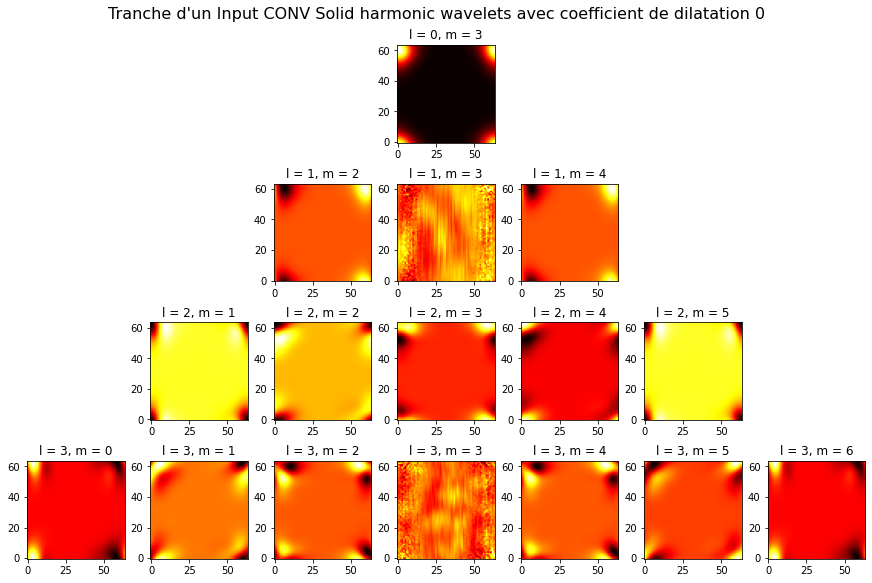

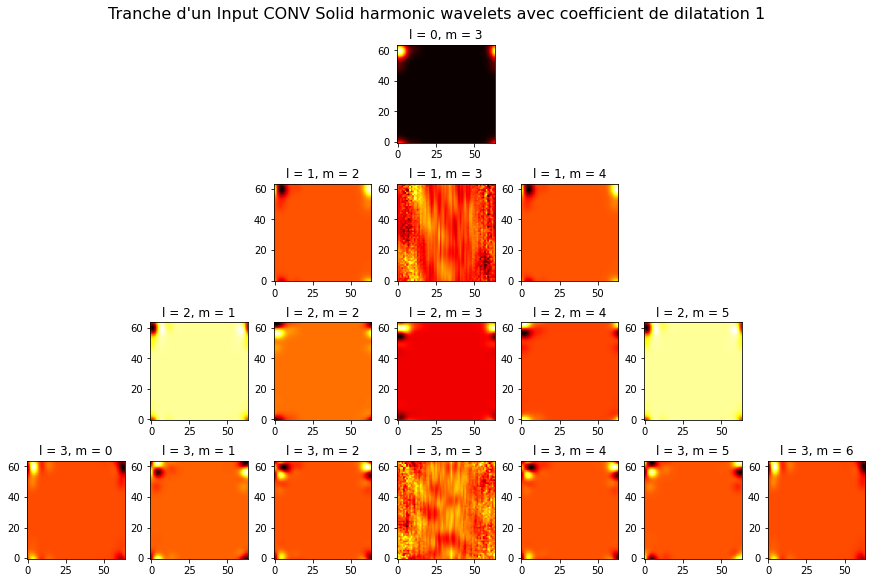

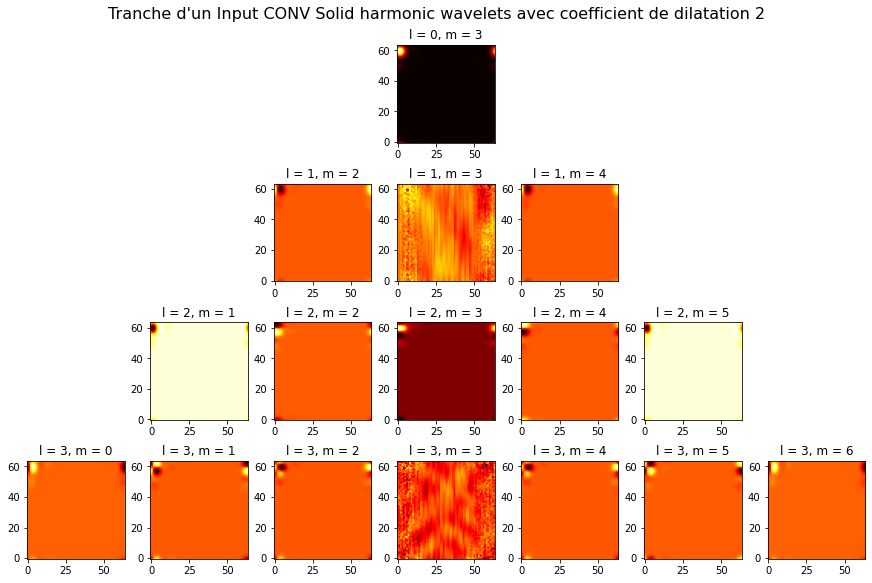

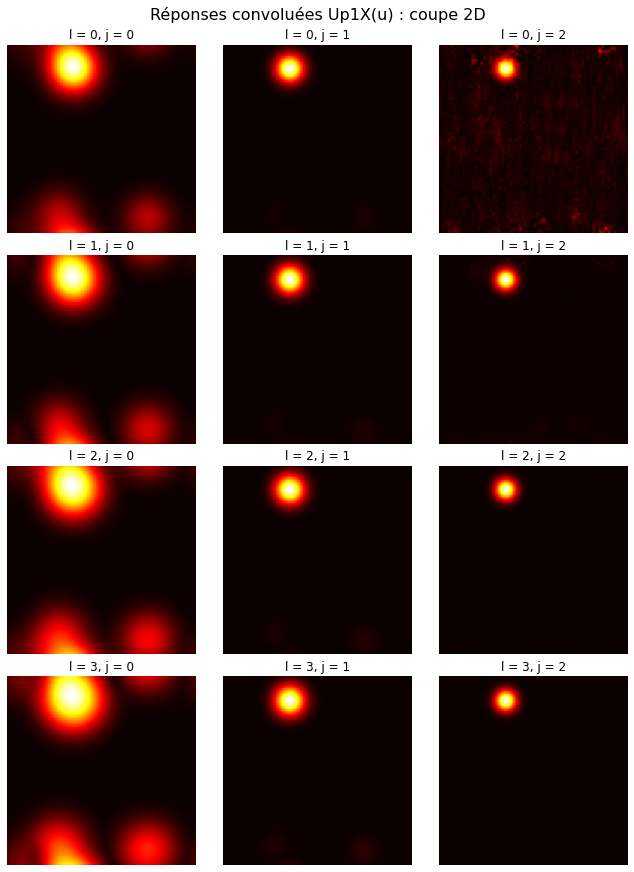

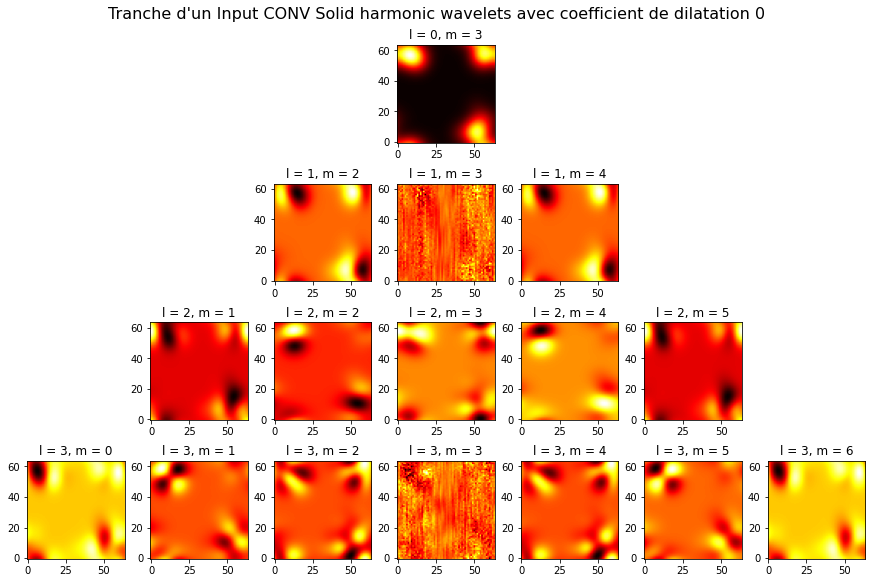

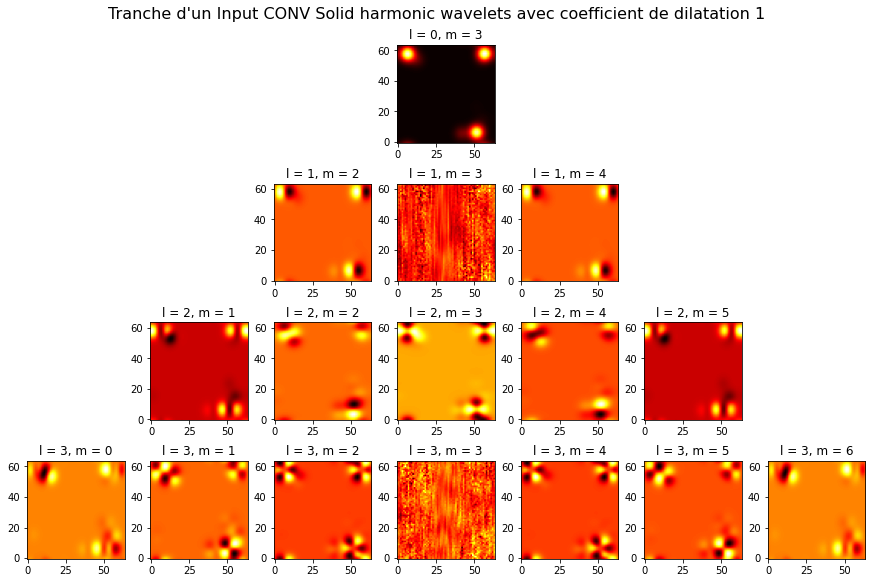

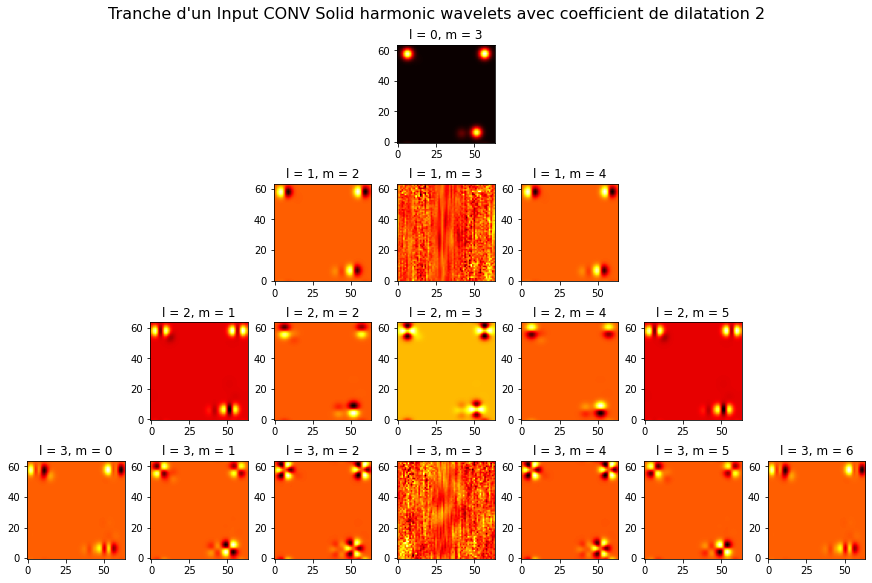

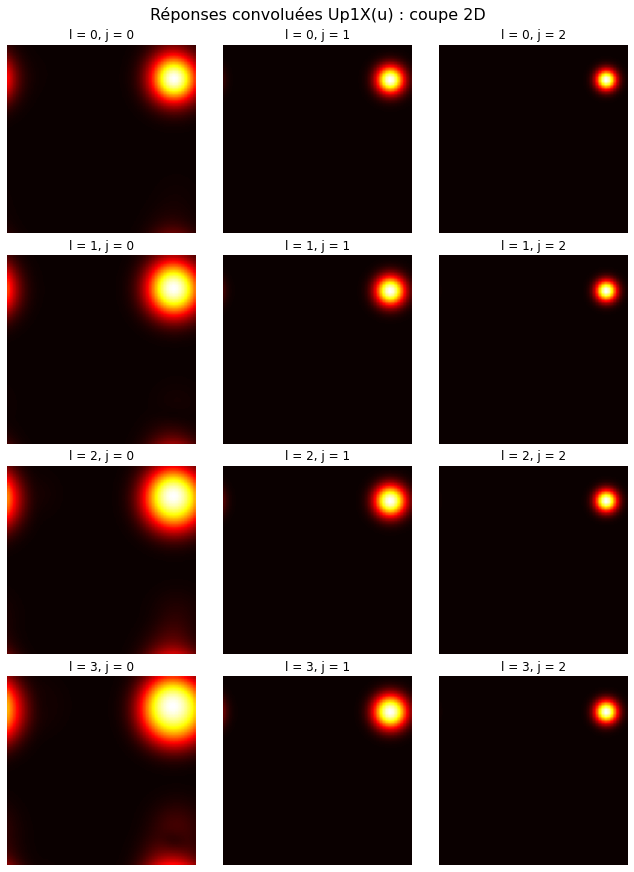

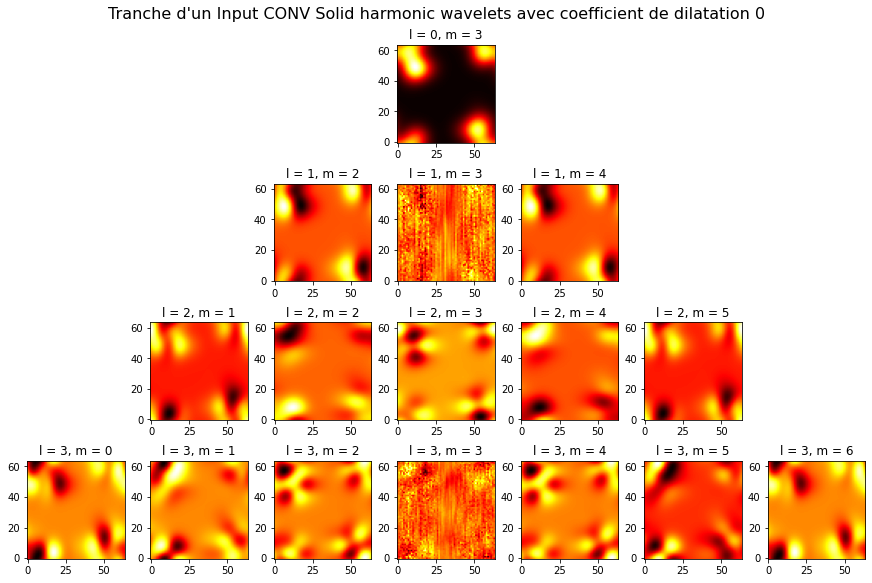

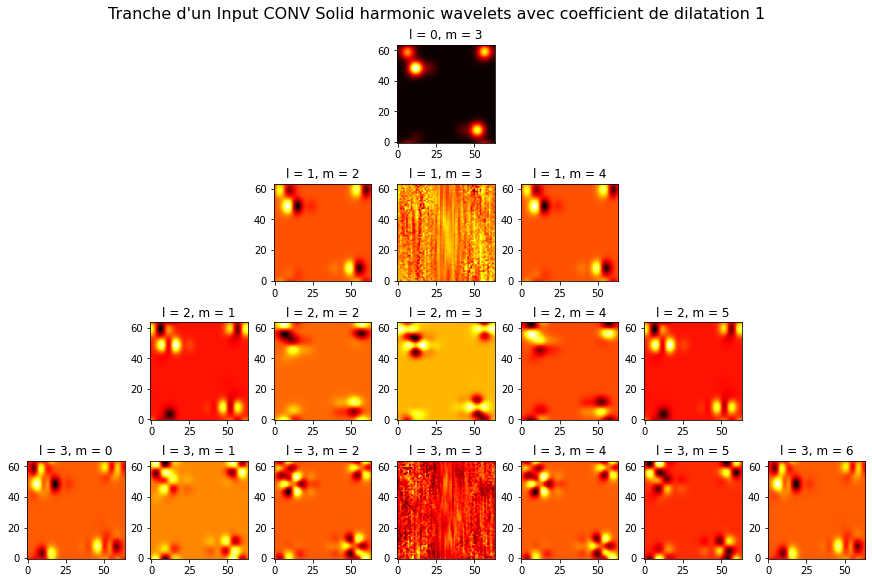

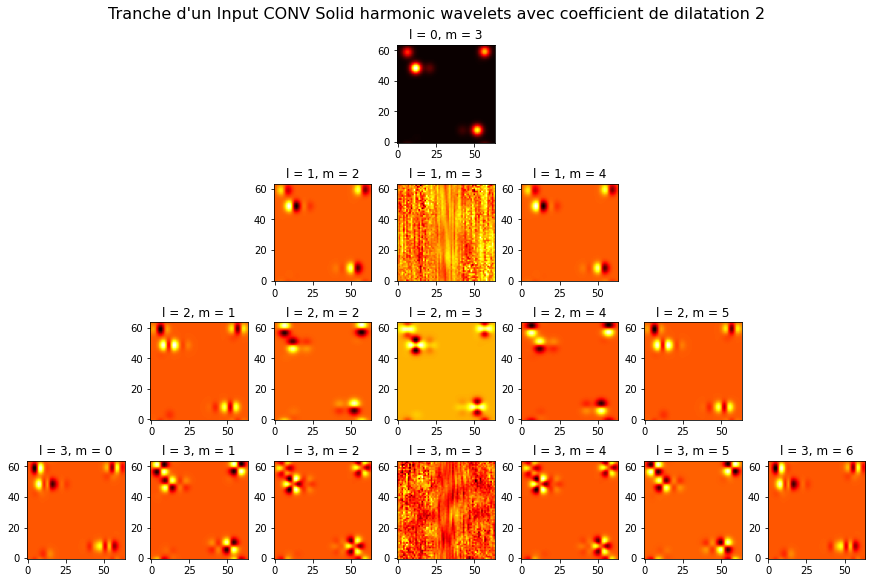

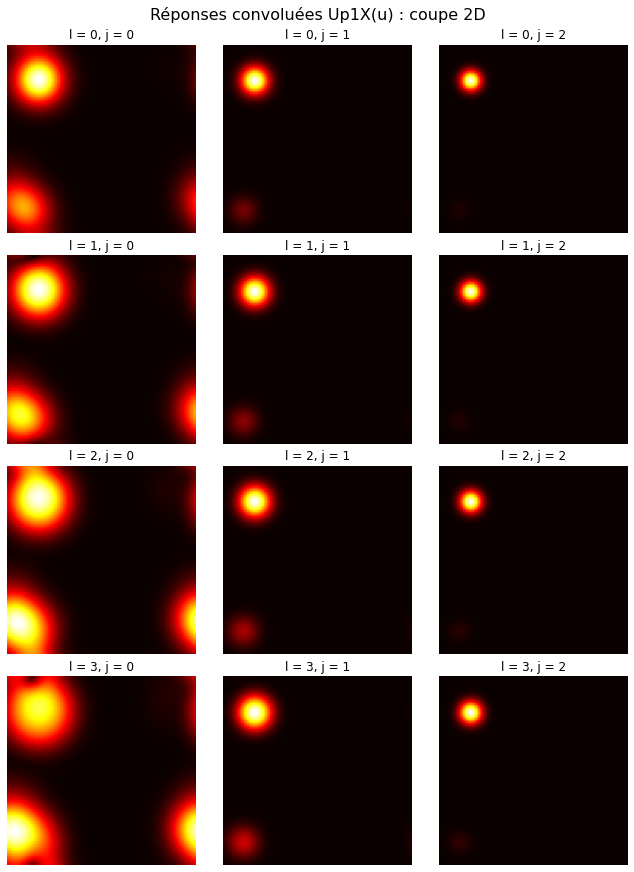

In [34]:
import pickle
l_scatering_filter = pickle.load(open("scattering_64_64_64.pkl", "rb"))
device = torch.device("cpu")
order_0, orders_1_and_2 = [], []


this_time = None
last_time = None
# for i in range(n_batches):
for i in range(3):

        this_time = time.time()
        if last_time is not None:
                dt = this_time - last_time
                print("Iteration {} ETA: [{:02}:{:02}:{:02}]".format(
                        i + 1, int(((n_batches - i - 1) * dt) // 3600),
                        int((((n_batches - i - 1) * dt) // 60) % 60),
                        int(((n_batches - i - 1) * dt) % 60)))
        else:
                print("Iteration {} ETA: {}".format(i + 1, '-'))
        last_time = this_time
        time.sleep(1)

        # Extract the current batch.
        start = i * batch_size
        end = min(start + batch_size, n_molecules)

        pos_batch = pos[start:end]
        full_batch = full_charges[start:end]
        val_batch = valence_charges[start:end]

        # Calculate the density map for the nuclear charges and transfer
        # to PyTorch.
        full_density_batch = generate_weighted_sum_of_gaussians(grid,
                pos_batch, full_batch, sigma)
        full_density_batch = torch.from_numpy(full_density_batch)
        full_density_batch = full_density_batch.to(device).float()



        print("full_density_batch shape:", full_density_batch.shape)
        
        #affichage que des convulition x ondelettes
        l_conv_product_real = []
        for l in range(L):
                scatering_filter = l_scatering_filter[l]
                


                #appliquer fft scatering_filter[0,:,:,:,:,0] et full_density_batch
                fft_filter = torch.fft.fftn(scatering_filter[:,:,:,:,:,0])
                fft_density = torch.fft.fftn(full_density_batch[:, :, :, :])

                # Calculer le produit de convolution
                conv_product = torch.fft.ifftn(fft_filter * fft_density)
                l_conv_product_real.append(conv_product.real)
                print("conv_product shape:", conv_product.real.shape)
               
        plot_pyramid_subplots(l_conv_product_real,coef_dilation=0)  # Afficher la pyramide de subplots pour la dilatation j=0
        plot_pyramid_subplots(l_conv_product_real,coef_dilation=1)  # Afficher la pyramide de subplots pour la dilatation j=0
        plot_pyramid_subplots(l_conv_product_real,coef_dilation=2)  # Afficher la pyramide de subplots pour la dilatation j=0


        l_conv_product_real = []

        for l in range(L):
                scatering_filter = l_scatering_filter[l]  # shape: (J, 2*ell+1, M, N, O, 2)
                
                # Pour stocker les convolutions pour chaque dilatation j
                convs_for_l = []

                for j in range(scatering_filter.shape[0]):  # boucle sur les dilatations j
                        sum_m_squared = 0
                        for m in range(scatering_filter.shape[1]):  # boucle sur m
                                filt_m_real = scatering_filter[j, m, :, :, :, 0]
                                filt_m_imag = scatering_filter[j, m, :, :, :, 1]
                                filt_m = filt_m_real + 1j * filt_m_imag

                                fft_filter = torch.fft.fftn(filt_m)
                                fft_density = torch.fft.fftn(full_density_batch[0])  # batch size 1

                                conv = torch.fft.ifftn(fft_filter * fft_density)
                                sum_m_squared += torch.abs(conv) ** 2
                        
                        U_jl = torch.sqrt(sum_m_squared)  # sqrt sum over m
                        convs_for_l.append(U_jl.real.cpu())  # stocker par dilatation j

                # convs_for_l est une liste des convolutions pour chaque j (dilatation)
                l_conv_product_real.append(torch.stack(convs_for_l))  # stack pour créer un tenseur (J, M, N, O)
                print(f"l = {l}, conv_product shape:", l_conv_product_real[-1].shape)
        plot_scattering_grid(l_conv_product_real, save_path="grille_up1x.png")  # par ex. affichage dilatation j=0



In [ ]:
scattering.filters[0].shape

In [ ]:
scattering.filters[0][0,:,:,:,:,0] .shape # (6, 4, 4)
